# Compare clustering results

This jupyter notebook (python) compares the clustering results between Phydelity, multi-state birth-death method by Barido-Sotani et al. and cutpoint-based method (WPGMA) results by Villandre et al. 

## Load libraries

In [1]:
from __future__ import division
import os 
import itertools 
import re
import numpy as np
import subprocess 
import json
import csv
import numpy as np
import matplotlib
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import mutual_info_score as mi_score
from matplotlib import pyplot as plt

# Inputs

In [2]:
simulation_trees_folder = './data/trees'
network_annotations_fname = './data/network_annotations.csv'
wpgma_cluster_results_folder = './data/wpgma'
msbd_cluster_results_folder = './data/MSBD'
annotated_trees_folder = './data/annotated_trees'

## Search for optimal cutpoint (WPGMA) clustering results; Calculate clustering assessment metrics for both MSBD and optimal cutpoint clustering results

We calculate two clustering assessment metrics against the real network annotations: 
1. Adjusted Rand Index (ARI)
2. Variation of Information (VI) 

In [3]:
# calculate information entropy
def entropy(probability_distribution):
    return -sum([p * np.log(p) for p in probability_distribution])

# parse network annotations file 
fileindices_to_leaf_to_nanno = {}
with open(network_annotations_fname, 'rb') as fhandle: 
    for l, line in enumerate(csv.reader(fhandle)):
        if l == 0:
            continue
        network, weight_index, sim_index, leaf, n_anno = line 
        network = network.replace('"', '')
        try: 
            fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)][leaf] = n_anno
        except:
            fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)] = {leaf:n_anno}

# parse raw newick files 
fileindidces_to_msbd_clustering_results = {}
fileindidces_to_wpgma_clustering_results = {}
fileindices_to_size = {}

for tfname in os.listdir(simulation_trees_folder):
    network, weight_index, sim_index = re.search('([A-Z])_(\d+)_(\d+)\.nwk', tfname).group(1,2,3)
    
    # reference network annotations 
    tiplabel_to_rcluster = fileindices_to_leaf_to_nanno[(network, weight_index, sim_index)]
    
    # generate annotated (with network anno) newick tree files 
    treefhandle = open('{}/{}'.format(simulation_trees_folder, tfname)).readline()
    prev_end = 0
    annotated_tree = []
    number_of_leaves = 0
    for expr in re.finditer('(\(|,)(\d+):', treefhandle):
        annotated_tree.append(treefhandle[prev_end:expr.start()+1])
        
        leaf = expr.group(2)
        number_of_leaves += 1
        n_anno = tiplabel_to_rcluster[leaf]
        annotated_tree.append('{}_N{}'.format(leaf, n_anno))
        
        prev_end = expr.end() - 1
    annotated_tree.append(treefhandle[prev_end:])
    
    with open('./data/annotated_trees/annotated_{}_{}_{}.nwk'.format(network, weight_index, sim_index), 'w') as output:
        output.write(''.join(annotated_tree))
    fileindices_to_size[(network, weight_index, sim_index)] = number_of_leaves
    
    # get MSBD clustering results
    labels_true = []
    labels_pred = []
    with open('{}/{}_{}_{}.csv'.format(msbd_cluster_results_folder, network, weight_index, sim_index), 'rb') as fhandle:
        for l, line in enumerate(csv.reader(fhandle)):
            if l == 0:
                continue 
            
            leaf, msbd_cluster, n_anno = line
            labels_true.append(n_anno)
            labels_pred.append(msbd_cluster)
    
    msbd_ari = ari(labels_true, labels_pred)
    
    msbd_mi = mi_score(labels_true, labels_pred)
    true_H_msbd = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    msbd_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    vi_msbd = msbd_H + true_H_msbd - (2*msbd_mi)
    
    fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)] = (msbd_ari, vi_msbd)
    
    # get best cutpoint clustering results (WPGMA)
    # wpgma label 
    with open('{}/{}_{}_{}_wpgma.csv'.format(wpgma_cluster_results_folder, network, weight_index, sim_index), 'rb') as fhandle:
        tiplabel_to_cutpoint_to_wpgmacluster = {}
        for l, line in enumerate(csv.reader(fhandle)):
            if l == 0:
                cutpoint_to_index = {cutpoint:c for c, cutpoint in enumerate(line) if cutpoint != ''}
            else:
                tiplabel = line[0]
                for cutpoint, c in cutpoint_to_index.items():
                    try:
                        tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][cutpoint] = line[c]
                    except:
                        tiplabel_to_cutpoint_to_wpgmacluster[tiplabel] = {cutpoint:line[c]}

    tiplabel_list = tiplabel_to_rcluster.keys()
    labels_true = [tiplabel_to_rcluster[tiplabel] for tiplabel in tiplabel_list]

    max_ari_wpgma = -9
    best_cutpoint = ''
    for cutpoint in cutpoint_to_index.keys():
        labels_pred = [tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][cutpoint] for tiplabel in tiplabel_list]
        curr_ari = ari(labels_true, labels_pred)
        if curr_ari > max_ari_wpgma:
            max_ari_wpgma = curr_ari
            best_cutpoint = cutpoint
    
    labels_pred = [tiplabel_to_cutpoint_to_wpgmacluster[tiplabel][best_cutpoint] for tiplabel in tiplabel_list]
    wpgma_mi = mi_score(labels_true, labels_pred)
    true_H_wpgma = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    wpgma_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    vi_wpgma = wpgma_H + true_H_wpgma - (2*wpgma_mi)    
    
    fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)] = (max_ari_wpgma, vi_wpgma)

## Cluster simulation datasets using Phydelity

In [4]:
os.chdir('./results/')

# read log file 
fileindidces_to_phydelity_clustering_results = {}

try:
    with open('results.log', 'rb') as fhandle: 
        for line in csv.reader(fhandle):
            network, weight_index, sim_index, phydelity_ari, vi_phydelity, coverage = line
            fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)] = tuple(map(float, [phydelity_ari, vi_phydelity, coverage]))
except:
    pass

logfile = open('results.log', 'a')
#logfile = open('results.log', 'w')

for tfname in os.listdir('.' + simulation_trees_folder):
    network, weight_index, sim_index = re.search('([A-Z])_(\d+)_(\d+)\.nwk', tfname).group(1,2,3)
    
    if (network, weight_index, sim_index) in fileindidces_to_phydelity_clustering_results:
        continue
    
    cmd = ['phydelity.py', '--tree', '../data/annotated_trees/annotated_{}'.format(tfname), '--pdf_tree']
    subprocess.call(cmd)
    
    # parse cluster file 
    clusterfname = re.search('cluster_phydelity_k\d+_sol0_annotated_{}_{}_{}\.txt'.format(network, weight_index, sim_index),
                             str(os.listdir('./'))).group()
    labels_true = []
    labels_pred = []
    with open(clusterfname, 'rb') as fhandle:
        for l, line in enumerate(csv.reader(fhandle, delimiter='\t')):
            if l == 0:
                continue 
            cluster, leaf = line[:2]
            labels_true.append(re.search('N(\d+)$', leaf).group(1))
            labels_pred.append(cluster)
    
    phydelity_ari = ari(labels_true, labels_pred)
    
    phydelity_mi = mi_score(labels_true, labels_pred)
    true_H_phydelity = entropy([labels_true.count(lab) / len(labels_true) for lab in list(set(labels_true))])
    phydelity_H = entropy([labels_pred.count(lab) / len(labels_pred) for lab in list(set(labels_pred))])
    vi_phydelity = phydelity_H + true_H_phydelity - (2*phydelity_mi)
    
    total_count = fileindices_to_size[(network, weight_index, sim_index)]
    coverage = len(labels_pred)/total_count
    
    fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)] = (phydelity_ari, vi_phydelity, coverage) 
    
    subprocess.call('rm cluster_phydelity_* tree_phydelity_* gurobi.log', shell=True)
    
    
    logfile.write('{}\n'.format(','.join(map(str, [network, weight_index, sim_index, phydelity_ari, 
                                                   vi_phydelity, coverage]))))
    logfile.flush()
    
logfile.close()
os.chdir('../')

## Plot clustering metrics plots 

Network: B, Weight: 25%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              80.5%(8.5%)    0.89(0.10)    0.20(0.15)
WPGMA                 100.0%(0.0%)    0.88(0.09)    0.25(0.18)
MSBD                  100.0%(0.0%)    0.72(0.19)    0.55(0.29)


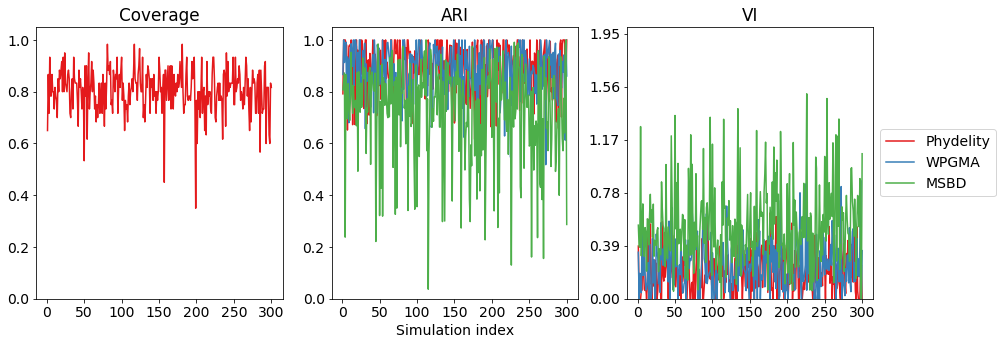

Network: B, Weight: 50%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              79.8%(7.9%)    0.90(0.10)    0.19(0.15)
WPGMA                 100.0%(0.0%)    0.89(0.09)    0.23(0.18)
MSBD                  100.0%(0.0%)    0.63(0.24)    0.72(0.36)


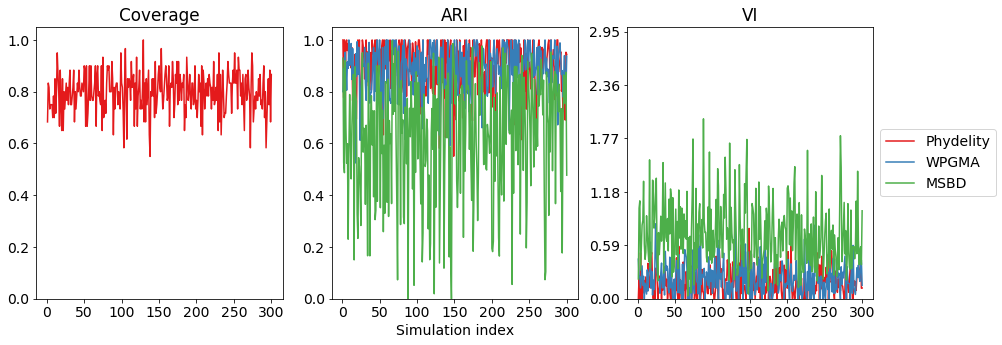

Network: B, Weight: 75%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              78.6%(7.9%)    0.89(0.09)    0.20(0.15)
WPGMA                 100.0%(0.0%)    0.92(0.08)    0.17(0.16)
MSBD                  100.0%(0.0%)    0.56(0.25)    0.82(0.39)


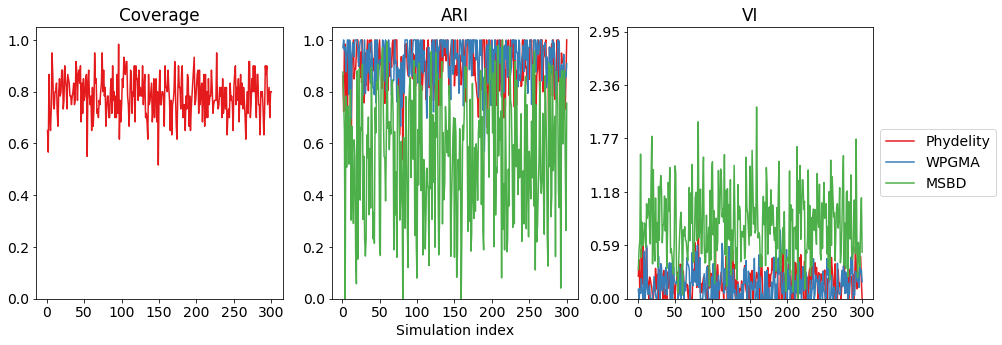

Network: B, Weight: 100%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              71.4%(9.0%)    0.88(0.10)    0.20(0.16)
WPGMA                 100.0%(0.0%)    0.96(0.06)    0.09(0.12)
MSBD                  100.0%(0.0%)    0.49(0.27)    0.93(0.44)


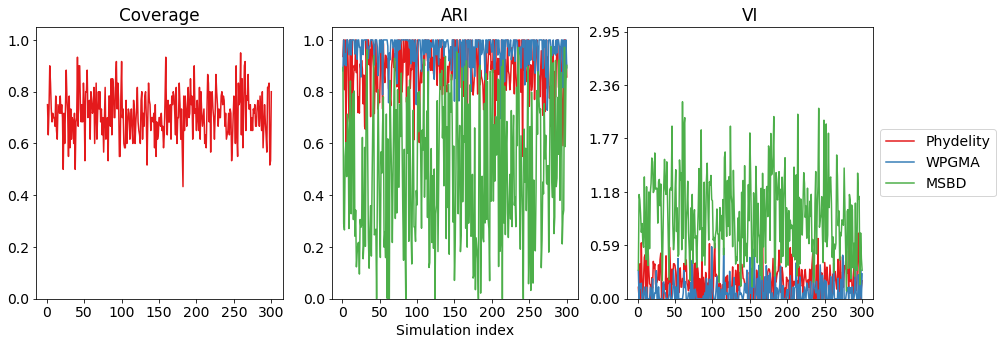

Network: C, Weight: 25%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              88.4%(2.9%)    0.49(0.05)    1.18(0.12)
WPGMA                 100.0%(0.0%)    0.44(0.05)    1.33(0.12)
MSBD                  100.0%(0.0%)    0.22(0.11)    1.80(0.37)


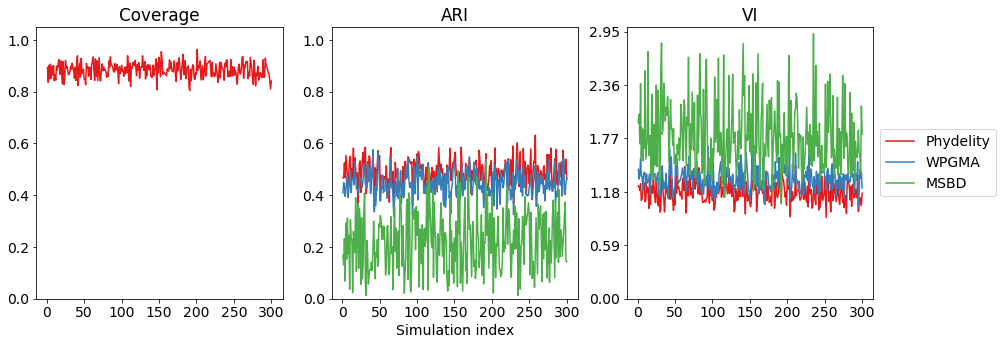

Network: C, Weight: 50%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              88.4%(2.7%)    0.51(0.05)    1.13(0.10)
WPGMA                 100.0%(0.0%)    0.47(0.05)    1.28(0.12)
MSBD                  100.0%(0.0%)    0.22(0.10)    1.85(0.36)


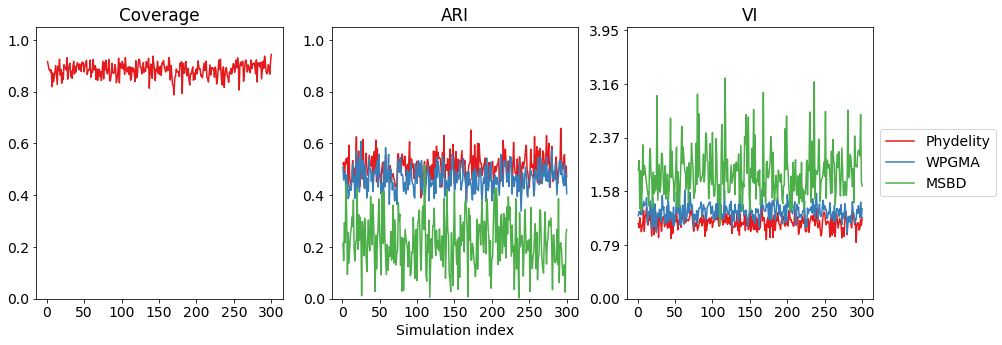

Network: C, Weight: 75%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              88.5%(2.6%)    0.55(0.05)    1.04(0.12)
WPGMA                 100.0%(0.0%)    0.50(0.05)    1.19(0.11)
MSBD                  100.0%(0.0%)    0.20(0.09)    1.95(0.38)


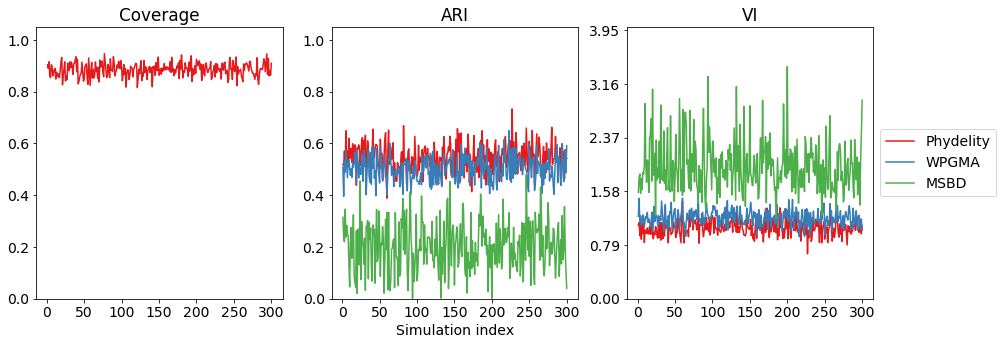

Network: C, Weight: 100%
Method [Mean(SD)]              Cov           ARI            VI
Phydelity              88.1%(2.8%)    0.59(0.05)    0.95(0.10)
WPGMA                 100.0%(0.0%)    0.56(0.05)    1.07(0.11)
MSBD                  100.0%(0.0%)    0.19(0.09)    2.02(0.35)


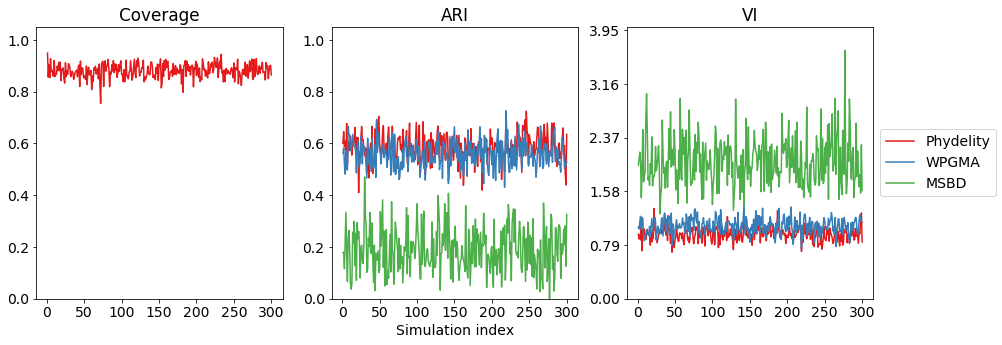

In [5]:
networks = ['B', 'C']
weight_indices = map(str, range(1,5))
sim_indices = map(str, range(1,301))
color_cycle = ['#e41a1c' , '#377eb8', '#4daf4a'] # phydelity, wpgma, msbd

matplotlib.rcParams.update({'font.size': 14})

for network in networks: 
    for weight_index in weight_indices:
        coverage = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][-1] for sim_index in sim_indices]
        
        phydelity_ari = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        msbd_ari = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        wpgma_ari = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][0] for sim_index in sim_indices]
        
        
        phydelity_vi = [fileindidces_to_phydelity_clustering_results[(network, weight_index, sim_index)][1] for sim_index in sim_indices]
        msbd_vi = [fileindidces_to_msbd_clustering_results[(network, weight_index, sim_index)][-1] for sim_index in sim_indices]
        wpgma_vi = [fileindidces_to_wpgma_clustering_results[(network, weight_index, sim_index)][-1] for sim_index in sim_indices]
        
        print 'Network: {}, Weight: {:.0%}'.format(network, {1:0.25, 2:0.5, 3:0.75, 4:1.}[int(weight_index)])
        print '{:<20}{:>14}{:>14}{:>14}'.format('Method [Mean(SD)]', 'Cov', 'ARI', 'VI')
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('Phydelity', np.mean(coverage),
                                                                                    np.std(coverage),
                                                                                    np.mean(phydelity_ari),
                                                                                    np.std(phydelity_ari),
                                                                                    np.mean(phydelity_vi),
                                                                                    np.std(phydelity_vi))
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('WPGMA', 1.,
                                                                                    0.,
                                                                                    np.mean(wpgma_ari),
                                                                                    np.std(wpgma_ari),
                                                                                    np.mean(wpgma_vi),
                                                                                    np.std(wpgma_vi))
        print '{:<20}{:>8.1%}({:<4.1%}){:>8.2f}({:>4.2f}){:>8.2f}({:>4.2f})'.format('MSBD', 1.,
                                                                                    0.,
                                                                                    np.mean(msbd_ari),
                                                                                    np.std(msbd_ari),
                                                                                    np.mean(msbd_vi),
                                                                                    np.std(msbd_vi))
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
        x_interval = int(np.ceil(300/6))
        
        # plot coverage 
        ax1.plot(range(1, 301), coverage, color=color_cycle[0])
        ax1.set_ylim(0, 1.05)
        ax1.set_yticks(np.arange(0, 1.05, 0.2))
        ax1.set_xticks(range(0, 301, x_interval))
        ax1.set_title("Coverage")
        
        ax2.plot(range(1, 301), phydelity_ari, label='Phydelity', color=color_cycle[0])        
        ax2.plot(range(1, 301), wpgma_ari, label='WPGMA', color=color_cycle[1])
        ax2.plot(range(1, 301), msbd_ari, label='MSBD', color=color_cycle[2])
        ax2.set_ylim(0, 1.05)
        ax2.set_yticks(np.arange(0, 1.05, 0.2))
        ax2.set_xlabel('Simulation index')
        ax2.set_xticks(range(0, 301, x_interval))
        ax2.set_title("ARI")
        
        ax3.plot(range(1, 301), phydelity_vi, label='Phydelity', color=color_cycle[0])
        ax3.plot(range(1, 301), wpgma_vi, label='WPGMA', color=color_cycle[1])
        ax3.plot(range(1, 301), msbd_vi, label='MSBD', color=color_cycle[2])
        y_max = np.ceil(np.max([np.max(phydelity_vi), np.max(wpgma_vi), np.max(msbd_vi)])+0.05)
        ax3.set_ylim(0, y_max)
        ax3.set_yticks(np.arange(0, y_max, (y_max-0.05)/5))
        ax3.set_xticks(range(0, 301, x_interval))
        ax3.set_title("VI")
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        f.savefig("{}_{}_stats.pdf".format(network, weight_index), bbox_inches='tight')
        plt.show()